SET UP

In [89]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 6, 6

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

LOADING THE DATASET

In [55]:
data = pd.read_csv(r"/content/creditcard.csv")
data=data.iloc[1:50000,]
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
5,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.0


EXPLORATION

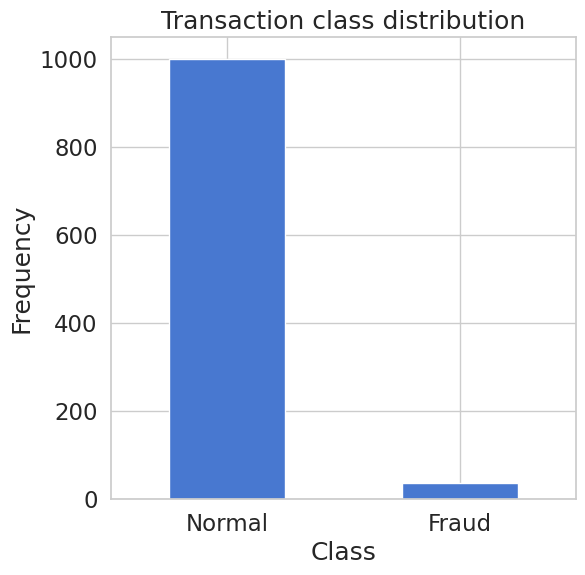

In [90]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");


In [57]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [58]:
frauds.shape

(38, 31)

In [59]:
normal.shape

(1000, 31)

In [60]:
frauds.Amount.describe()

count      38.000000
mean       75.730526
std       304.521215
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1809.680000
Name: Amount, dtype: float64

In [61]:
normal.Amount.describe()

count    1000.000000
mean       63.496610
std       190.449901
min         0.000000
25%         6.197500
50%        15.950000
75%        50.000000
max      4002.880000
Name: Amount, dtype: float64

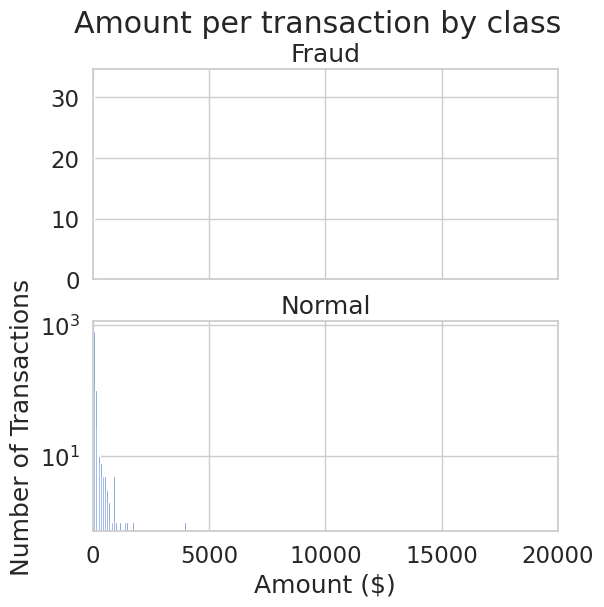

In [91]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

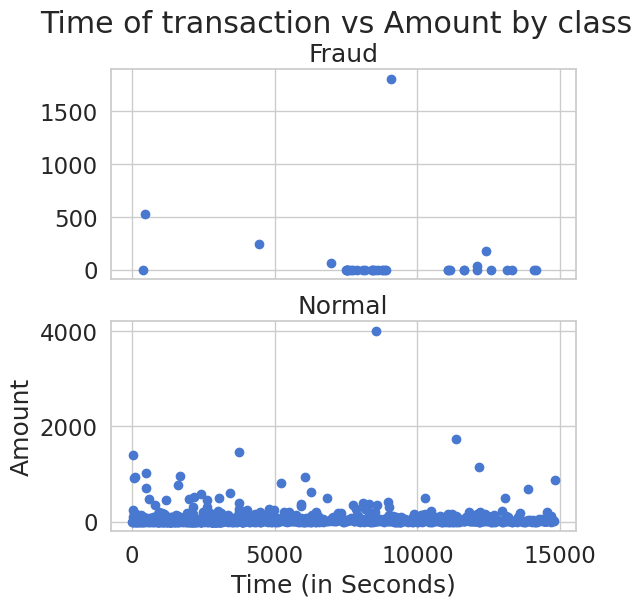

In [92]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()


PREPARING THE DATA

In [64]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [65]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [66]:
X_train.shape

(800, 29)

BUILDING THE MODEL

In [67]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [68]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [69]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
25/25 [==============================] - 2s 14ms/step - loss: 1.1086 - accuracy: 0.0825 - val_loss: 1.6396 - val_accuracy: 0.1058
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 1.0604 - accuracy: 0.1525 - val_loss: 1.6018 - val_accuracy: 0.1202
Epoch 3/100
 1/25 [>.............................] - ETA: 0s - loss: 0.9220 - accuracy: 0.2188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 5ms/step - loss: 1.0227 - accuracy: 0.1612 - val_loss: 1.5713 - val_accuracy: 0.1394
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 0.9902 - accuracy: 0.1700 - val_loss: 1.5414 - val_accuracy: 0.1635
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 0.9619 - accuracy: 0.2013 - val_loss: 1.5175 - val_accuracy: 0.2067
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9396 - accuracy: 0.2362 - val_loss: 1.5002 - val_accuracy: 0.2500
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.9220 - accuracy: 0.2713 - val_loss: 1.4838 - val_accuracy: 0.2548
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9017 - accuracy: 0.2950 - val_loss: 1.4650 - val_accuracy: 0.2740
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 0.8838 - accuracy: 0.3075 - val_loss: 1.4520 - val_accuracy: 0.2837
Epoch 10/100
25/25 [=====

In [70]:
autoencoder = load_model('model.h5')

EVALUATION

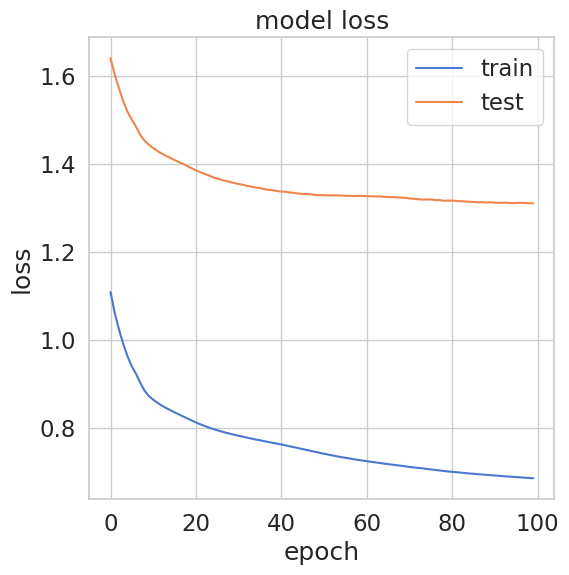

In [93]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [72]:
predictions = autoencoder.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [73]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [74]:
error_df.describe()

,reconstruction_error,true_class
count,208.000000,208.000000
mean,1.309263,0.038462
std,4.962941,0.192772
min,0.085528,0.000000
25%,0.302717,0.000000
50%,0.458357,0.000000
75%,0.765124,0.000000
max,64.341966,1.000000


RECONSTRUCTION ERROR WITHOUT FRAUD

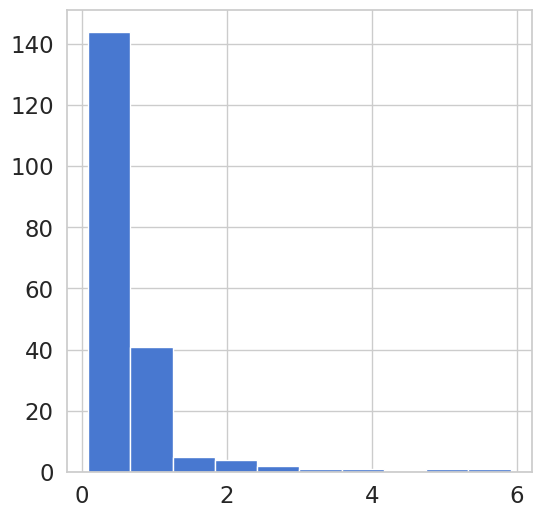

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

RECONSTRUCTION ERROR WITH FRAUD

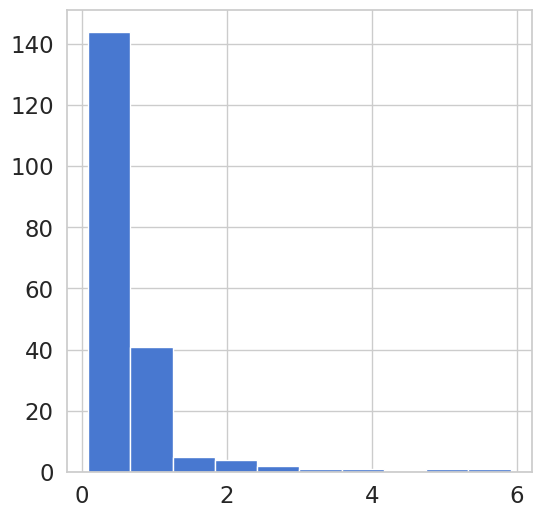

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [77]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

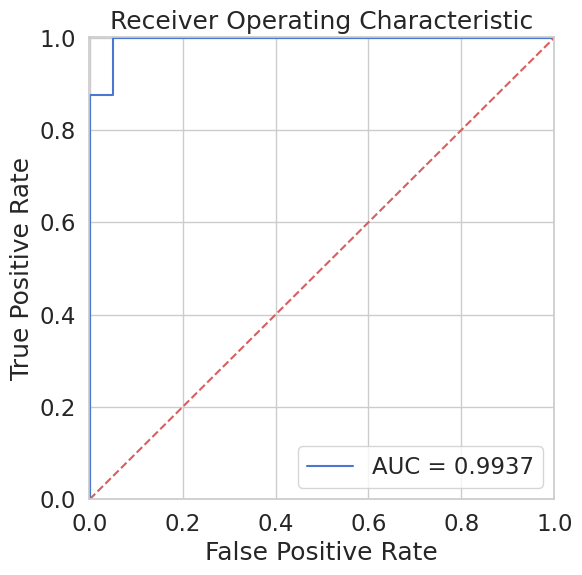

In [96]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

PRECISION VS RECALL

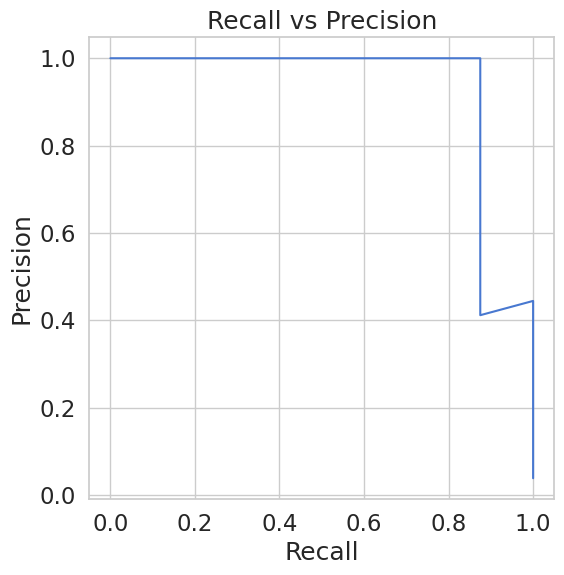

In [97]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



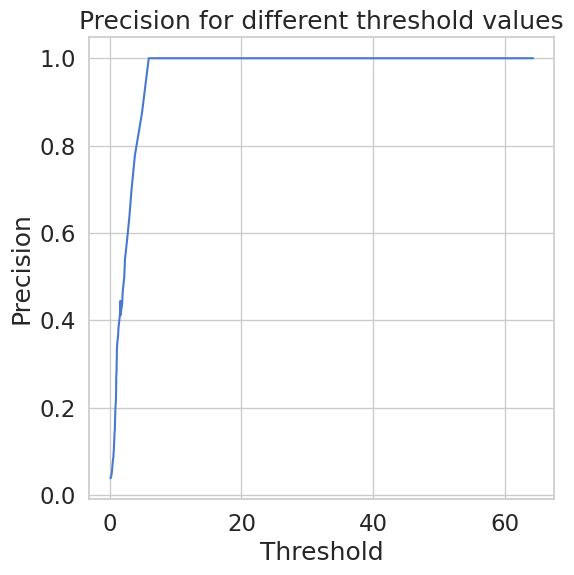

In [98]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

PREDICTION

In [81]:
threshold = 2.9

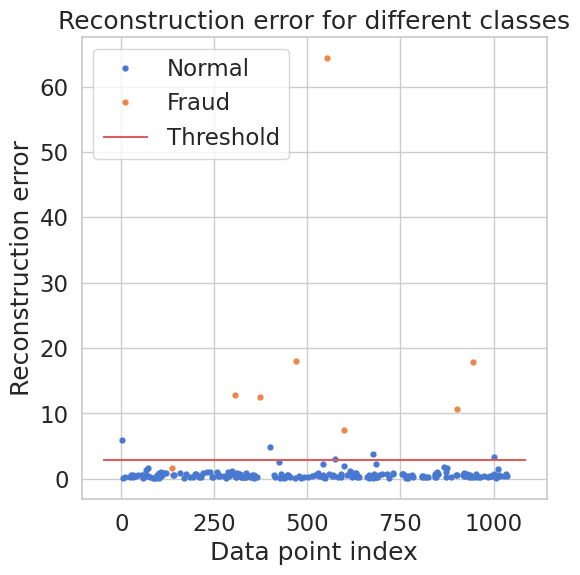

In [99]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


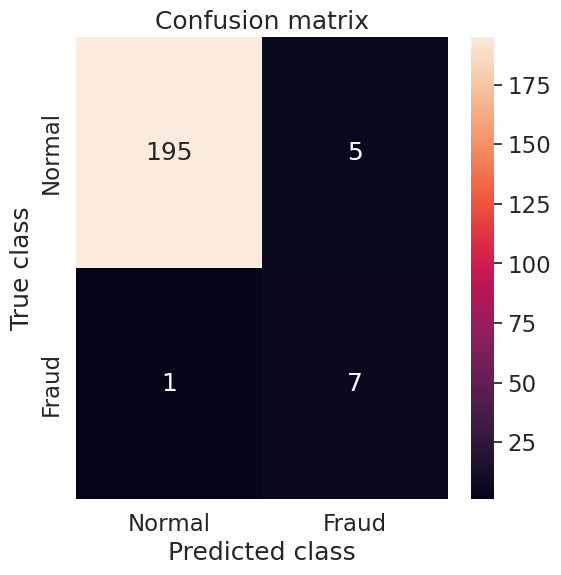

In [102]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
